In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d quora/question-pairs-dataset

Dataset URL: https://www.kaggle.com/datasets/quora/question-pairs-dataset
License(s): other


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('question-pairs-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('questions.csv')

In [ ]:
df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
235115,235115,463204,463205,Where can I get wonderful floor tiles company ...,Where can I meet my every flooring tiles requi...,1
341657,341657,669682,669683,Interpersonal Interaction: What is the most in...,How can I approach my crush?,0
305669,305669,600172,600173,What is your biggest hopeless regret?,What was the biggest mistake of your life?,1
78817,78817,156576,156577,How do I get rid of acne naturally?,How can I get rid from my acnes?,1
288657,288657,567222,567223,"What is the difference between 'had been', 'ha...","""if X used Y, how would it have been different...",0


In [ ]:
df.isnull().sum()

,0
id,0
qid1,0
qid2,0
question1,1
question2,2
is_duplicate,0


In [ ]:
df.dropna(axis=0, inplace=True)

In [ ]:
df.duplicated().value_counts()

,count
False,404348


In [ ]:
len(df[df['qid1'] == df['qid2']])

0

In [ ]:
len(set(df['qid1']) & set(df['qid2']))

7474

In [ ]:
df['is_duplicate'].value_counts()/len(df) * 100

,count
is_duplicate,
0,63.074876
1,36.925124


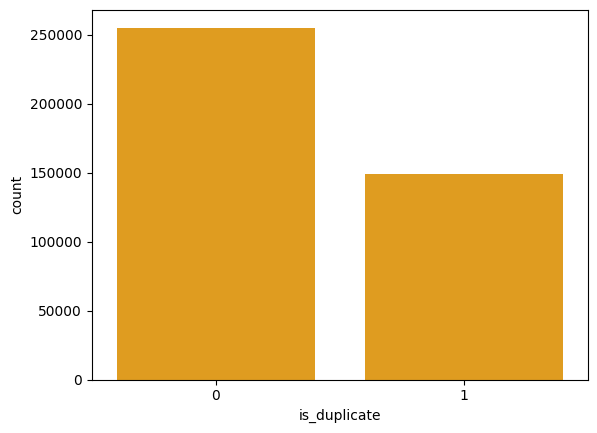

In [ ]:
sns.countplot(df, x='is_duplicate', color='orange')
plt.show()

In [ ]:
df.drop(['id', 'qid1', 'qid2'], axis=1, inplace=True)

In [ ]:
len(df)

404348

400K rows is a lot to process

In [ ]:
df = df.sample(30000, random_state = 42)

In [ ]:
df['is_duplicate'].value_counts()/len(df) * 100

,count
is_duplicate,
0,63.463333
1,36.536667


In [ ]:
!pip install contractions
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 11.0 MB/s eta 0:00:00


In [ ]:
import contractions
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = stopwords.words('english')
ps = PorterStemmer()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def preprocess_text(text):
    text = text.lower().strip()
    text = text.replace('%', ' percent')
    text = text.replace('$', ' dollar ')
    text = text.replace('₹', ' rupee ')
    text = text.replace('€', ' euro ')
    text = text.replace('@', ' at ')
    text = contractions.fix(text)
    text = word_tokenize(text)
    text = [word for word in text if word.isalnum()]
    text = [word for word in text if word not in stop_words]
    text = [ps.stem(word) for word in text]
    text = ' '.join(text)
    return text

In [ ]:
df['question1'] = df['question1'].apply(preprocess_text)
df['question2'] = df['question2'].apply(preprocess_text)

In [ ]:
s = ''.join(df['question1'])
t = ''.join(df['question2'])

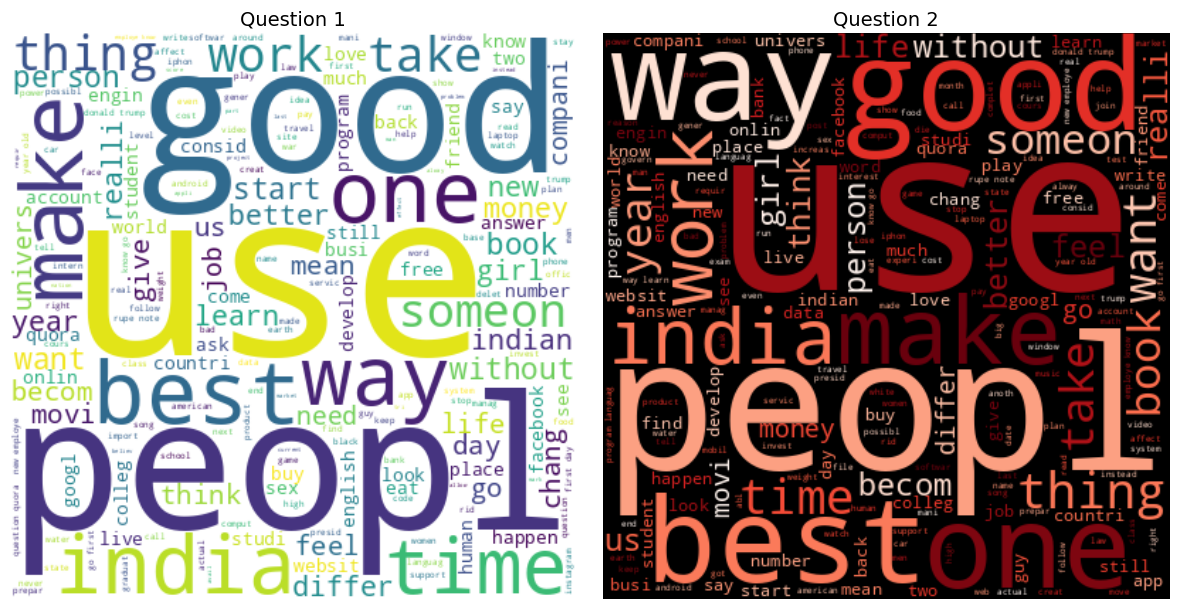

In [ ]:
wordcloud_q1 = WordCloud(width=400, height=400, background_color="white").generate(s)
wordcloud_q2 = WordCloud(width=400, height=400, background_color="black", colormap="Reds").generate(t)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(wordcloud_q1, interpolation="bilinear")
axes[0].set_title("Question 1", fontsize=14)
axes[0].axis("off")

axes[1].imshow(wordcloud_q2, interpolation="bilinear")
axes[1].set_title("Question 2", fontsize=14)
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
X = df['question1'] + ' ' + df['question2']
y = df['is_duplicate']

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
cv = CountVectorizer(max_features=5000)
X_train_cv = cv.fit_transform(X_train).toarray()
X_test_cv = cv.transform(X_test).toarray()

In [ ]:
def get_models(X_train, X_test, y_train, y_test):
    accuracys = {}
    models = {}

    print("Training Logistic Regression Model")
    lr = LogisticRegression()
    lr.fit(X_train,y_train)
    lr_pred = lr.predict(X_test)
    accuracys['lr'] = accuracy_score(y_test,lr_pred)
    models['lr'] = lr
    print(f"Trained Logistic Regression Model ACCURACY = {accuracys['lr']}")
    print('-'*10 + '\n')

    print("Training Naive Bayes Model")
    mnb = MultinomialNB()
    mnb.fit(X_train,y_train)
    mnb_pred = mnb.predict(X_test)
    accuracys['mnb'] = accuracy_score(y_test,mnb_pred)
    models['mnb'] = mnb
    print(f"Trained Naive Bayes Model ACCURACY = {accuracys['mnb']}")
    print('-'*10 + '\n')

    print("Training Random Forest Model")
    rf = RandomForestClassifier()
    rf.fit(X_train,y_train)
    rf_pred = rf.predict(X_test)
    accuracys['rf'] = accuracy_score(y_test,rf_pred)
    models['rf'] = rf
    print(f"Trained Random Forest Model ACCURACY = {accuracys['rf']}")
    print('-'*10 + '\n')

    print("Training XGB Model")
    xgb = XGBClassifier()
    xgb.fit(X_train,y_train)
    xgb_pred = xgb.predict(X_test)
    accuracys['xgb'] = accuracy_score(y_test,xgb_pred)
    models['xgb'] = xgb
    print(f"Trained XGB Model ACCURACY = {accuracys['xgb']}")
    print('-'*10+ '\n')

    return models, accuracys

In [ ]:
models, accuracys = get_models(X_train_cv, X_test_cv, y_train, y_test)

Training Logistic Regression Model
Trained Logistic Regression Model ACCURACY = 0.712
----------

Training Naive Bayes Model
Trained Naive Bayes Model ACCURACY = 0.709
----------

Training Random Forest Model
Trained Random Forest Model ACCURACY = 0.7346666666666667
----------

Training XGB Model
Trained XGB Model ACCURACY = 0.7258333333333333
----------



In [ ]:
cv = CountVectorizer(max_features=7000, ngram_range=(1,3))
X_train_cv = cv.fit_transform(X_train).toarray()
X_test_cv = cv.transform(X_test).toarray()

In [ ]:
models, accuracys = get_models(X_train_cv, X_test_cv, y_train, y_test)

Training Logistic Regression Model
Trained Logistic Regression Model ACCURACY = 0.7138333333333333
----------

Training Naive Bayes Model
Trained Naive Bayes Model ACCURACY = 0.7246666666666667
----------

Training Random Forest Model
Trained Random Forest Model ACCURACY = 0.7323333333333333
----------

Training XGB Model
Trained XGB Model ACCURACY = 0.726
----------



using TFIDF

In [ ]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

In [ ]:
models, accuracys = get_models(X_train_tfidf, X_test_tfidf, y_train, y_test)

Training Logistic Regression Model
Trained Logistic Regression Model ACCURACY = 0.7243333333333334
----------

Training Naive Bayes Model
Trained Naive Bayes Model ACCURACY = 0.7155
----------

Training Random Forest Model
Trained Random Forest Model ACCURACY = 0.743
----------

Training XGB Model
Trained XGB Model ACCURACY = 0.7216666666666667
----------



using WORD2VEC

In [ ]:
!pip install numpy==1.24.3
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 47.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.2.1 requires numpy>=1.26, but you have numpy 1.24.3 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
pymc 5.21.1 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.3 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.3 w

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 17.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
pymc 5.21.1 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.


In [ ]:
import gensim
from nltk import sent_tokenize
from gensim.utils import simple_preprocess
from tqdm import tqdm

In [ ]:
df = pd.read_csv("questions.csv")

In [ ]:
df.dropna(axis = 0, inplace = True)

In [ ]:
df.drop(['id', 'qid1', 'qid2'], axis=1, inplace=True)

In [ ]:
df['question1'] = df['question1'].apply(preprocess_text)
df['question2'] = df['question2'].apply(preprocess_text)

In [ ]:
df['text'] = df['question1'] + ' ' + df['question2']

In [ ]:
questions = []
for doc in df['text']:
    for sentence in sent_tokenize(doc):
        questions.append(simple_preprocess(sentence))

In [ ]:
model = gensim.models.Word2Vec(
    window = 10,
    min_count = 2
)

In [ ]:
model.build_vocab(questions)
model.train(questions, total_examples=model.corpus_count, epochs=model.epochs)

(20017422, 21240930)

In [ ]:
len(model.wv.index_to_key)

33817

In [ ]:
model.wv.save("questions_vectors.kv")
model.save("questions_w2v.model")

In [ ]:
def document_vector(doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc.split() if word in model.wv.index_to_key]
    # Check if doc is empty after removing OOV words
    if not doc:
        # Return a zero vector of the appropriate size if doc is empty
        return np.zeros(model.vector_size)
    return np.mean(model.wv[doc], axis=0)


In [ ]:
document_vector(df['text'].values[0])

array([-1.86819300e-01,  1.12047434e+00, -1.08969605e+00,  1.76029956e+00,
        4.55920577e-01, -9.02323127e-01,  7.36415293e-03,  1.90967512e+00,
        9.66655314e-02, -5.59916556e-01, -9.65347350e-01, -3.99771720e-01,
        1.35187693e-02,  1.26738414e-01, -8.97856876e-02,  4.52130467e-01,
        6.62777841e-01,  1.13697201e-01, -1.67216659e+00,  7.31822312e-01,
       -5.55670440e-01, -1.15218592e+00, -1.21404719e+00, -7.57865489e-01,
        1.17747314e-01, -2.17354938e-01, -3.69860530e-01, -7.27299929e-01,
        5.50798357e-01,  1.18006206e+00,  4.31985706e-01,  1.00410962e+00,
        6.12374768e-02,  8.39978755e-02, -3.99096668e-01, -1.34511702e-02,
       -3.77081990e-01,  8.28486204e-01, -1.76880538e-01,  4.98410016e-01,
        1.63062677e-01,  2.05499545e-01,  1.45456135e+00,  1.26198053e+00,
        6.48380399e-01,  4.66485023e-01,  9.33767319e-01, -6.20937884e-01,
        5.95291853e-01,  4.01989520e-01, -1.80485576e-01, -6.57132149e-01,
        6.71858191e-01, -

In [ ]:
X = []
for doc in tqdm(df['text'].values):
    X.append(document_vector(doc))

100%|██████████| 404348/404348 [08:06<00:00, 830.62it/s] 


In [ ]:
X = np.array(X)

In [ ]:
df = np.column_stack((X, np.array(df['is_duplicate'])))

In [ ]:
df.shape

(404348, 101)

In [ ]:
df = pd.DataFrame(df)
df = df.sample(30000, random_state = 42)

In [ ]:
X = df.drop(100, axis = 1)
y = df[100]

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
print("Training Random Forest Model")
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test,rf_pred)
print(f"Trained Random Forest Model ACCURACY = {accuracy}")
print('-'*10 + '\n')

Training Random Forest Model
Trained Random Forest Model ACCURACY = 0.7476666666666667
----------



In [ ]:
print("Training XGB Model")
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
xgb_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test,xgb_pred)
print(f"Trained XGB Model ACCURACY = {accuracy}")
print('-'*10+ '\n')

Training XGB Model
Trained XGB Model ACCURACY = 0.7423333333333333
----------



74.7666 or approx 75 is the highest we could get for this data without any feature engineering <br/>
lets try do some feature engineering for better accuracy

# **Advanced Feature Engineering**

In [ ]:
df = pd.read_csv('questions.csv')

In [ ]:
df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
76823,76823,152643,152644,How much is Byrd's salary on Judge Judy?,What is Judge Judy's IQ?,0
141721,141721,280512,280513,Who are some lesser known important historical...,Who are some lesser known important historical...,0
46841,46841,93264,93265,What is your favorite month of the year in Ame...,What is your favorite month of the year?,0
299215,299215,587699,259029,What is the difference between absolute gradin...,What are the precise differences between the a...,1
69856,69856,138850,138851,What is selection procedure in private medical...,What may be the procedure for private medical ...,1


In [ ]:
df.dropna(axis=0, inplace=True)

In [ ]:
df.drop(['id', 'qid1', 'qid2'], axis=1, inplace=True)

In [ ]:
df = df.sample(30000, random_state=42).reset_index()

In [ ]:
!pip install contractions
!pip install nltk

In [ ]:
import contractions
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = stopwords.words('english')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preprocess_text(text):
    text = text.lower().strip()
    text = text.replace('%', ' percent')
    text = text.replace('$', ' dollar ')
    text = text.replace('₹', ' rupee ')
    text = text.replace('€', ' euro ')
    text = text.replace('@', ' at ')
    text = contractions.fix(text)
    text = word_tokenize(text)
    text = [word for word in text if word.isalnum()]
    text = " ".join(text)
    return text

In [ ]:
df['question1'] = df['question1'].apply(preprocess_text)
df['question2'] = df['question2'].apply(preprocess_text)

thinking of adding columns


1.   length of questions
2.   number of common words
3.   length of stop words
4.   number of common stop words
5.   fuzzy features



In [ ]:
df['len_q1'] = df['question1'].apply(lambda x: len(x.split()))
df['len_q2'] = df['question2'].apply(lambda x: len(x.split()))

In [ ]:
def get_common_words(q1, q2):
    words1 = set(q1.split())
    words2 = set(q2.split())
    return len(words1 & words2)

In [ ]:
for i in range(len(df)):
    df.loc[i, 'common_words'] = get_common_words(df.loc[i, 'question1'], df.loc[i, 'question2'])

In [ ]:
def stopword_count(text):
    stp_text = [word for word in text.split() if word in stop_words]
    return len(stp_text)

In [ ]:
df['stop_words_q1'] = df['question1'].apply(stopword_count)
df['stop_words_q2'] = df['question2'].apply(stopword_count)

In [ ]:
def get_common_stpwords(q1, q2):
    stp_q1 = set([word for word in q1.split() if word in stop_words])
    stp_q2 = set([word for word in q2.split() if word in stop_words])
    return len(stp_q1 & stp_q2)

In [ ]:
for i in range(len(df)):
    df.loc[i, 'common_stpwords'] = get_common_stpwords(df.loc[i, 'question1'], df.loc[i, 'question2'])

In [ ]:
!pip install fuzzywuzzy
!pip install python-Levenshtein

In [ ]:
from fuzzywuzzy import fuzz
for i in range(len(df)):
    df.loc[i, 'fuzz_ratio'] = fuzz.ratio(df.loc[i, 'question1'], df.loc[i, 'question2'])
    df.loc[i, 'fuzz_partial_ratio'] = fuzz.partial_ratio(df.loc[i, 'question1'], df.loc[i, 'question2'])
    df.loc[i, 'token_sort_ratio'] = fuzz.token_sort_ratio(df.loc[i, 'question1'], df.loc[i, 'question2'])
    df.loc[i, 'token_set_ratio'] = fuzz.token_set_ratio(df.loc[i, 'question1'], df.loc[i, 'question2'])

In [ ]:
text_df = df[['question1', 'question2']]
df = df.drop(['question1', 'question2'], axis=1)

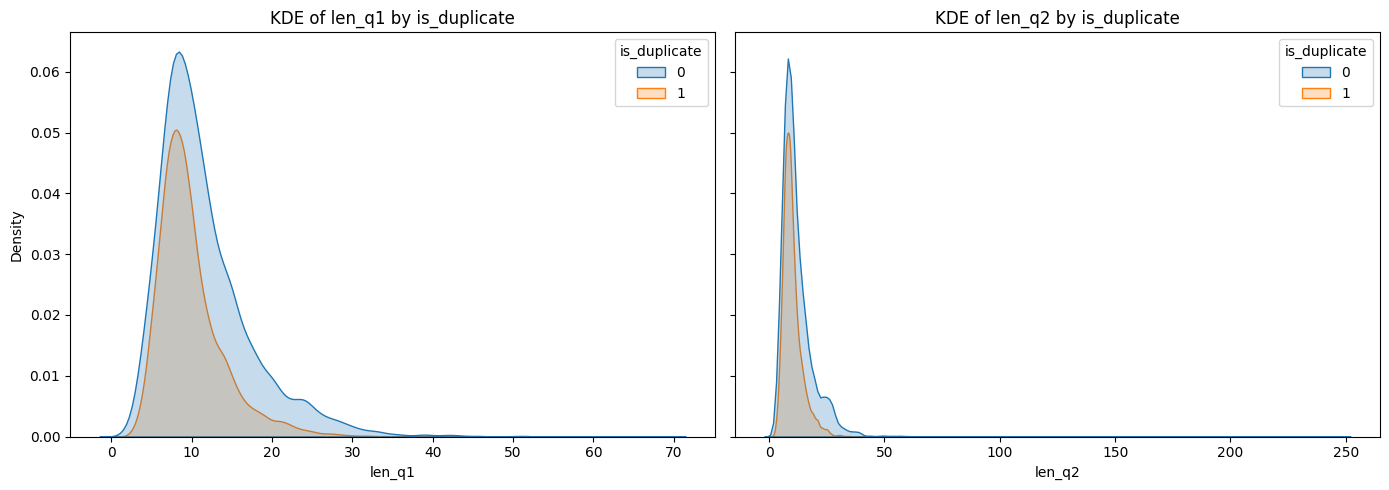

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# KDE for len_q1
sns.kdeplot(data=df, x='len_q1', hue='is_duplicate', fill=True, ax=axes[0])
axes[0].set_title("KDE of len_q1 by is_duplicate")
axes[0].set_xlabel("len_q1")

# KDE for len_q2
sns.kdeplot(data=df, x='len_q2', hue='is_duplicate', fill=True, ax=axes[1])
axes[1].set_title("KDE of len_q2 by is_duplicate")
axes[1].set_xlabel("len_q2")

plt.tight_layout()
plt.show()

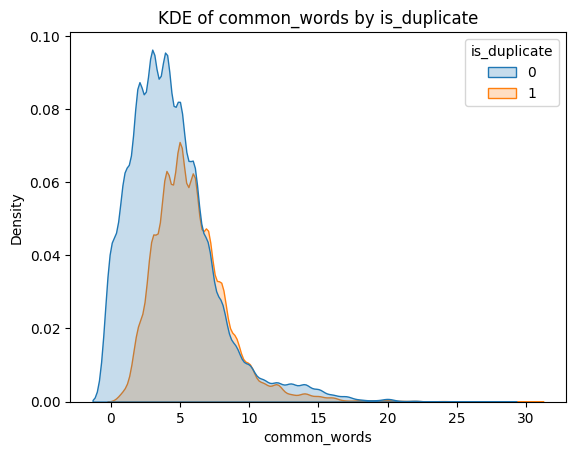

In [ ]:
sns.kdeplot(data=df, x='common_words', hue='is_duplicate', fill=True)
plt.title("KDE of common_words by is_duplicate")
plt.xlabel("common_words")
plt.show()

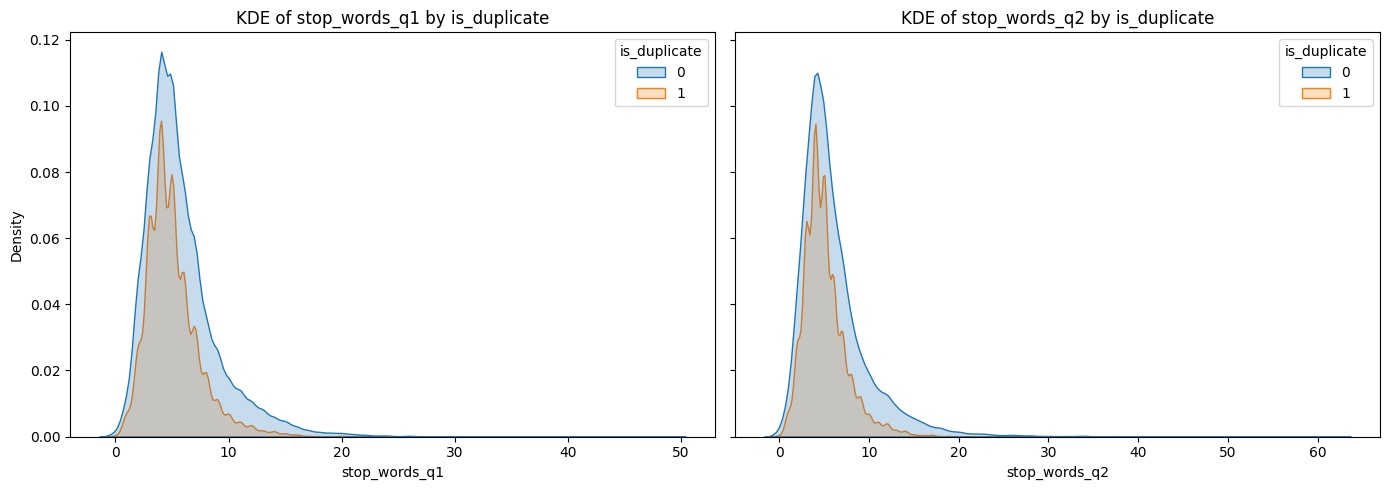

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# KDE for stop_words_q1
sns.kdeplot(data=df, x='stop_words_q1', hue='is_duplicate', fill=True, ax=axes[0])
axes[0].set_title("KDE of stop_words_q1 by is_duplicate")
axes[0].set_xlabel("stop_words_q1")

# KDE for stop_words_q1
sns.kdeplot(data=df, x='stop_words_q2', hue='is_duplicate', fill=True, ax=axes[1])
axes[1].set_title("KDE of stop_words_q2 by is_duplicate")
axes[1].set_xlabel("stop_words_q2")

plt.tight_layout()
plt.show()

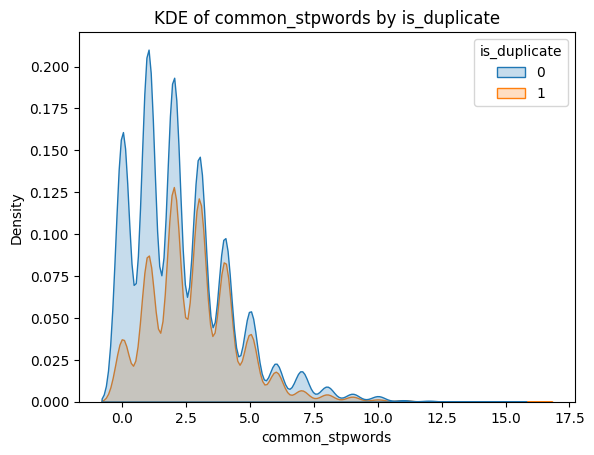

In [ ]:
sns.kdeplot(data=df, x='common_stpwords', hue='is_duplicate', fill=True)
plt.title("KDE of common_stpwords by is_duplicate")
plt.xlabel("common_stpwords")
plt.show()

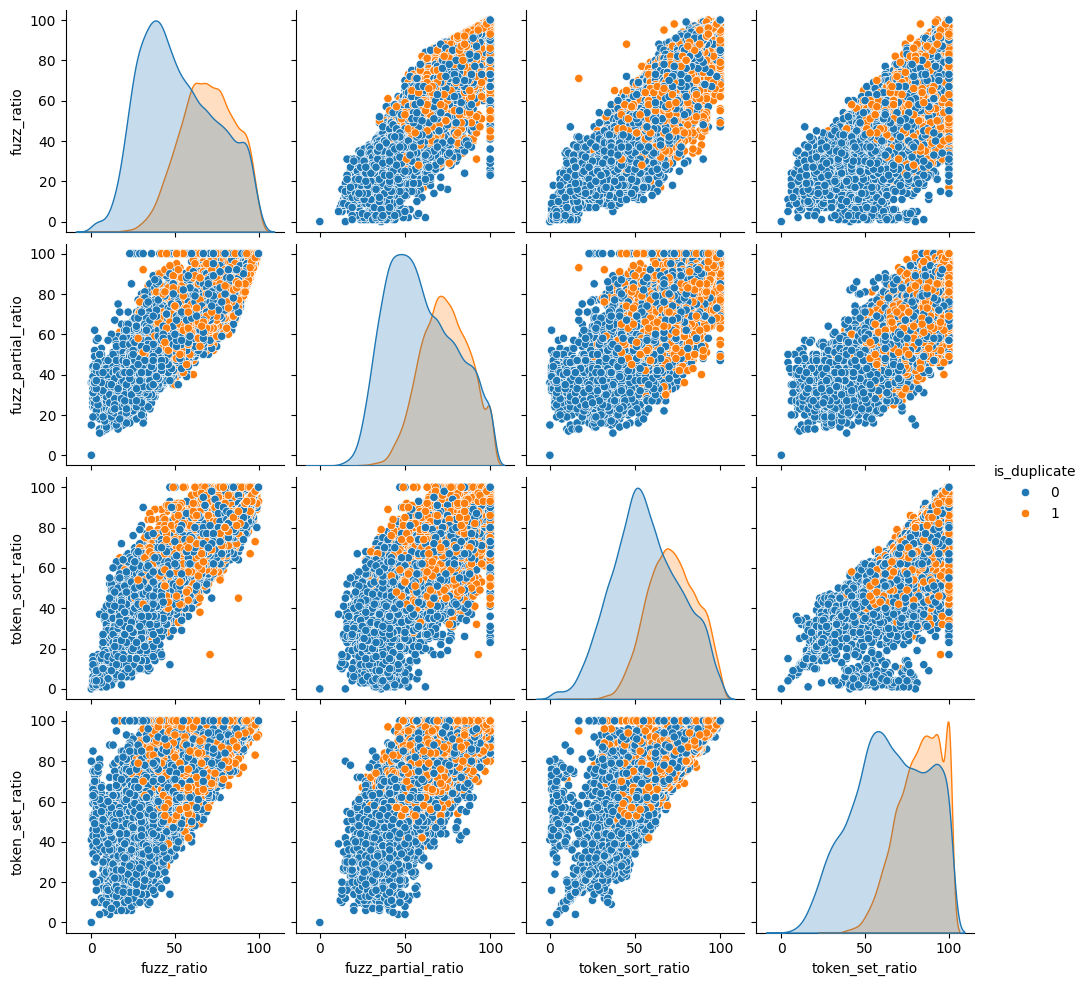

In [ ]:
sns.pairplot(df[['fuzz_ratio', 'fuzz_partial_ratio', 'token_sort_ratio', 'token_set_ratio', 'is_duplicate']], hue='is_duplicate')

Questions vary a lot in length.<br/>

A common word count of 5 might be a lot in a short question and not much in a long one.<br/>
Raw counts can bias the model toward longer questions.<br/>
Models may overfit to question length.<br/>

It may confuse signal (e.g., 5 common words sounds high, but it’s not if the question has 30 words).<br/>

Using ratios can help in this situation as seen in the case fuzzy ratios <br/>


In [ ]:
def jaccard_similarity(q1, q2):
    s1 = set(word_tokenize(q1))
    s2 = set(word_tokenize(q2))
    if not s1 or not s2:
        return 0
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [ ]:
for i in range(len(df)):
    df.loc[i, 'j_sim'] = jaccard_similarity(text_df.loc[i, 'question1'], text_df.loc[i, 'question2'])

Word Mover’s Distance

In [ ]:
!pip install numpy==1.26.0
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 53.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3


In [ ]:
from nltk.stem.porter import PorterStemmer
from gensim.models import Word2Vec
ps = PorterStemmer()

In [ ]:
!pip install pot

In [ ]:
model = Word2Vec.load("questions_w2v.model")

In [ ]:
def compute_wmd(q1, q2, model):
    q1_tokens = [ps.stem(word) for word in word_tokenize(q1)]
    q2_tokens = [ps.stem(word) for word in word_tokenize(q2)]
    if not q1_tokens or not q2_tokens:
        return float('inf')
    #normalised Word movers distance
    return 1 / (1 + model.wv.wmdistance(q1_tokens, q2_tokens))

In [ ]:
df['wmd'] = text_df.apply(lambda row: compute_wmd(row['question1'], row['question2'], model), axis=1)

In [ ]:
sfty = 1e-04
df['cw_min'] = df['common_words'] / (df[['len_q1', 'len_q2']].min(axis=1) + sfty)
df['cw_max'] = df['common_words'] / (df[['len_q1', 'len_q2']].max(axis=1) + sfty)
df['cw_mean'] = df['common_words'] / (df[['len_q1', 'len_q2']].mean(axis=1) + sfty)

In [ ]:
df['cstp_min'] = df['common_stpwords'] / (df[['len_q1', 'len_q2']].min(axis=1) + sfty)
df['cstp_max'] = df['common_stpwords'] / (df[['len_q1', 'len_q2']].max(axis=1) + sfty)
df['cstp_mean'] = df['common_stpwords'] / (df[['len_q1', 'len_q2']].mean(axis=1) + sfty)

In [ ]:
df['cstp_stplen_min'] = df['common_stpwords'] / (df[['stop_words_q1', 'stop_words_q2']].min(axis=1) + sfty)
df['cstp_stplen_max'] = df['common_stpwords'] / (df[['stop_words_q1', 'stop_words_q2']].max(axis=1) + sfty)
df['cstp_stplen_mean'] = df['common_stpwords'] / (df[['stop_words_q1', 'stop_words_q2']].mean(axis=1) + sfty)

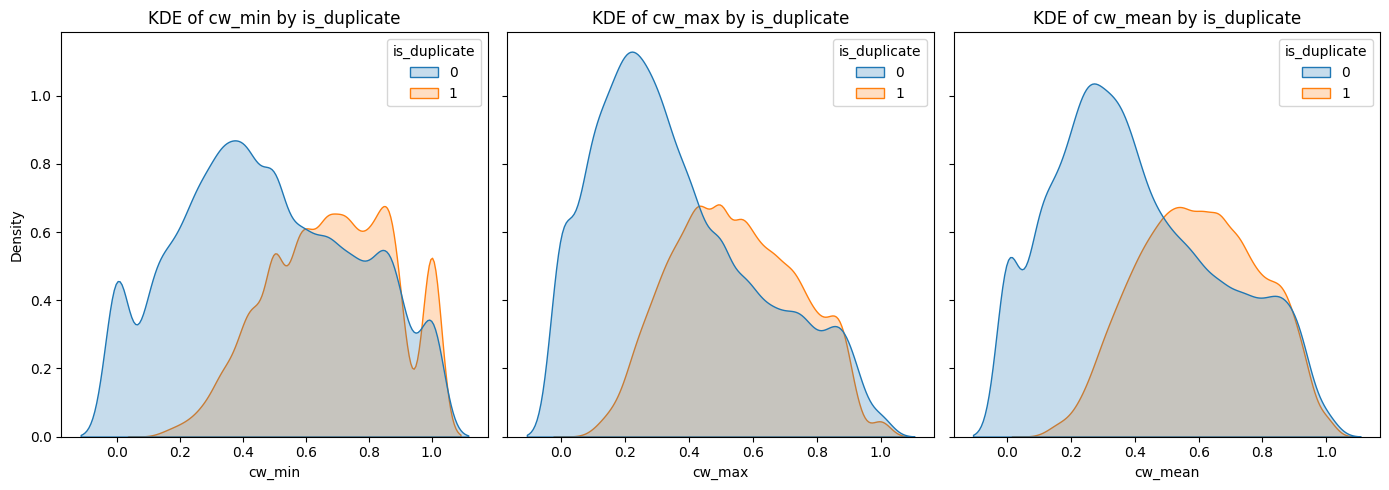

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

sns.kdeplot(data=df, x='cw_min', hue='is_duplicate', fill=True, ax=axes[0])
axes[0].set_title("KDE of cw_min by is_duplicate")
axes[0].set_xlabel("cw_min")


sns.kdeplot(data=df, x='cw_max', hue='is_duplicate', fill=True, ax=axes[1])
axes[1].set_title("KDE of cw_max by is_duplicate")
axes[1].set_xlabel("cw_max")


sns.kdeplot(data=df, x='cw_mean', hue='is_duplicate', fill=True, ax=axes[2])
axes[2].set_title("KDE of cw_mean by is_duplicate")
axes[2].set_xlabel("cw_mean")

plt.tight_layout()
plt.show()

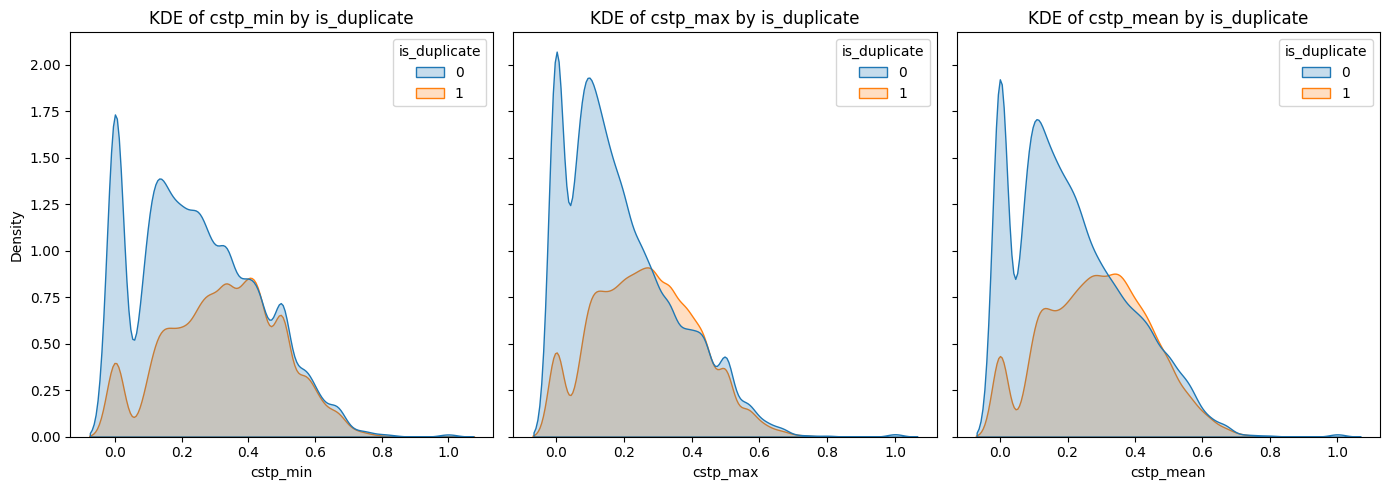

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

sns.kdeplot(data=df, x='cstp_min', hue='is_duplicate', fill=True, ax=axes[0])
axes[0].set_title("KDE of cstp_min by is_duplicate")
axes[0].set_xlabel("cstp_min")


sns.kdeplot(data=df, x='cstp_max', hue='is_duplicate', fill=True, ax=axes[1])
axes[1].set_title("KDE of cstp_max by is_duplicate")
axes[1].set_xlabel("cstp_max")


sns.kdeplot(data=df, x='cstp_mean', hue='is_duplicate', fill=True, ax=axes[2])
axes[2].set_title("KDE of cstp_mean by is_duplicate")
axes[2].set_xlabel("cstp_mean")

plt.tight_layout()
plt.show()

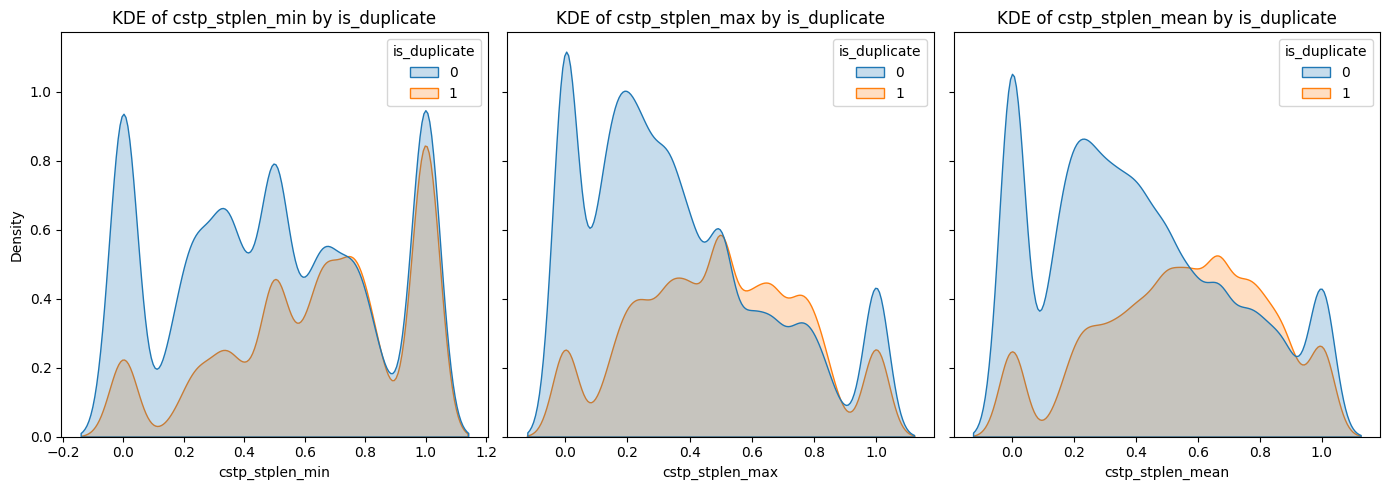

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

sns.kdeplot(data=df, x='cstp_stplen_min', hue='is_duplicate', fill=True, ax=axes[0])
axes[0].set_title("KDE of cstp_stplen_min by is_duplicate")
axes[0].set_xlabel("cstp_stplen_min")


sns.kdeplot(data=df, x='cstp_stplen_max', hue='is_duplicate', fill=True, ax=axes[1])
axes[1].set_title("KDE of cstp_stplen_max by is_duplicate")
axes[1].set_xlabel("cstp_stplen_max")


sns.kdeplot(data=df, x='cstp_stplen_mean', hue='is_duplicate', fill=True, ax=axes[2])
axes[2].set_title("KDE of cstp_stplen_mean by is_duplicate")
axes[2].set_xlabel("cstp_stplen_mean")

plt.tight_layout()
plt.show()

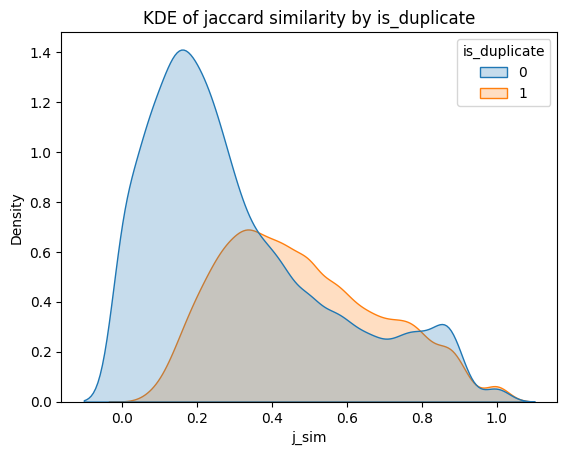

In [ ]:
sns.kdeplot(data=df, x='j_sim', hue='is_duplicate', fill=True)
plt.title("KDE of jaccard similarity by is_duplicate")
plt.xlabel("j_sim")
plt.show()

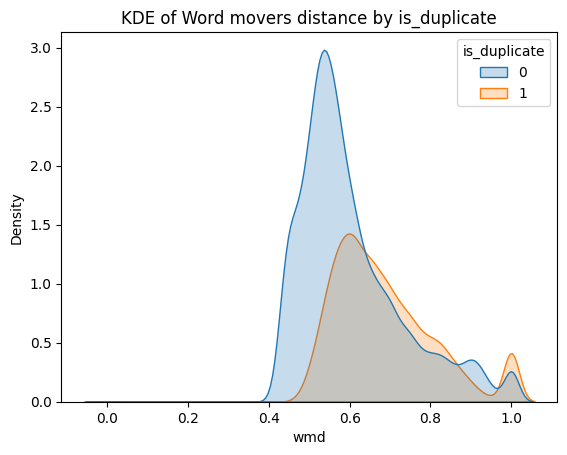

In [ ]:
sns.kdeplot(data=df, x='wmd', hue='is_duplicate', fill=True)
plt.title("KDE of Word movers distance by is_duplicate")
plt.xlabel("wmd")
plt.show()

In [ ]:
import umap
from sklearn.preprocessing import StandardScaler

In [ ]:
df.columns

Index(['len_q1', 'len_q2', 'common_words', 'stop_words_q1', 'stop_words_q2',
       'common_stpwords', 'fuzz_ratio', 'fuzz_partial_ratio',
       'token_sort_ratio', 'token_set_ratio', 'j_sim', 'wmd', 'cw_min',
       'cw_max', 'cw_mean', 'cstp_min', 'cstp_max', 'cstp_mean',
       'cstp_stplen_min', 'cstp_stplen_max', 'cstp_stplen_mean',
       'is_duplicate'],
      dtype='object')

In [ ]:
y = df['is_duplicate']
df = df.drop(['index', 'is_duplicate'], axis = 1)
X = StandardScaler().fit_transform(df)

KeyError: "['index'] not found in axis"

In [ ]:
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


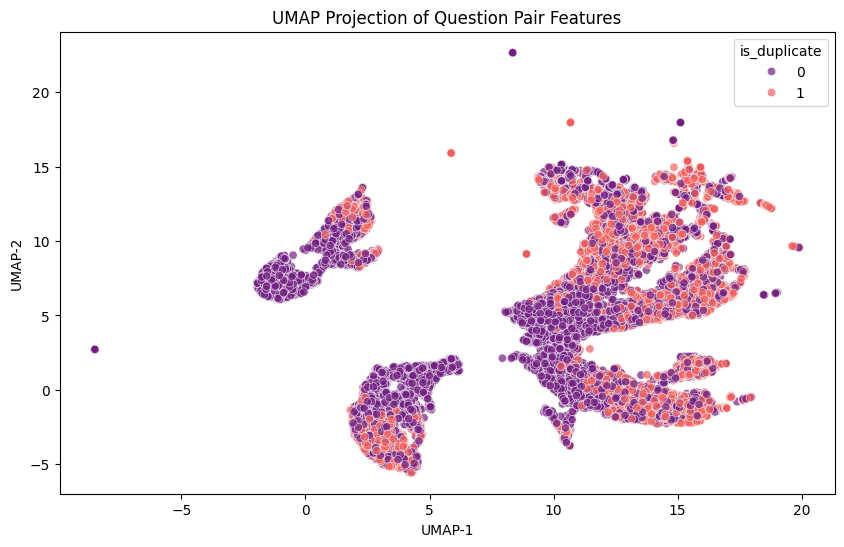

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=y, palette='magma', alpha=0.7)
plt.title('UMAP Projection of Question Pair Features')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.legend(title='is_duplicate')
plt.show()

In [ ]:
df['is_duplicate'] = y
feature_cols = df.drop('is_duplicate', axis=1).columns

<ipython-input-42-38463b0b1c3a>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='viridis')


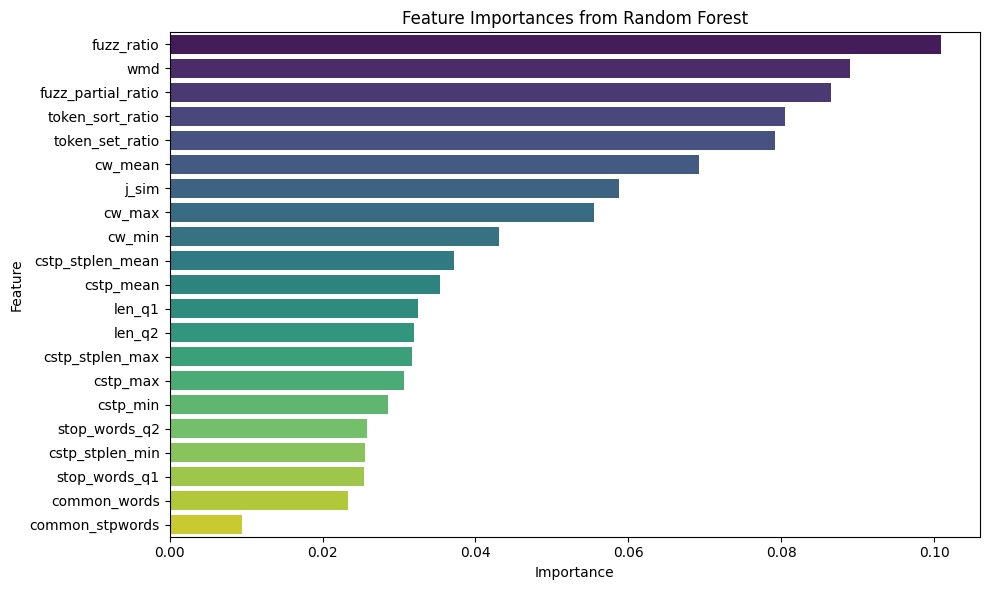

In [ ]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)


importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index, palette='viridis')
plt.title("Feature Importances from Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rf, X, y, n_repeats=10, random_state=42, scoring='accuracy')
perm_importance = pd.Series(result.importances_mean, index=feature_cols).sort_values(ascending=False)


<ipython-input-44-89b5eddcde23>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=perm_importance.values, y=perm_importance.index, palette='viridis')


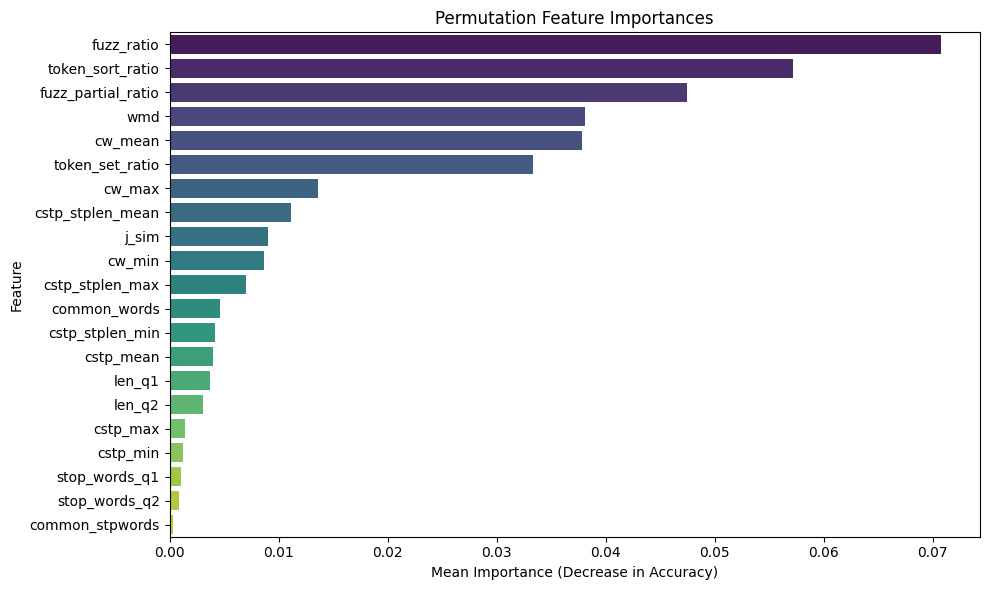

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=perm_importance.values, y=perm_importance.index, palette='viridis')
plt.title("Permutation Feature Importances")
plt.xlabel("Mean Importance (Decrease in Accuracy)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Top features like fuzz_ratio and cw_mean suggest:

String similarity is crucial. adding more:

jaccard_similarity

word mover's distance (WMD from gensim)

In [ ]:
from tqdm import tqdm

In [ ]:
def document_vector(doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc.split() if word in model.wv.index_to_key]
    # Check if doc is empty after removing OOV words
    if not doc:
        # Return a zero vector of the appropriate size if doc is empty
        return np.zeros(model.vector_size)
    return np.mean(model.wv[doc], axis=0)

In [ ]:
text_df['text'] = text_df['question1'] + ' ' + text_df['question2']

In [ ]:
X = []
for doc in tqdm(text_df['text'].values):
    X.append(document_vector(doc))

100%|██████████| 30000/30000 [05:14<00:00, 95.40it/s] 


In [ ]:
y = df['is_duplicate']

In [ ]:
df.columns

Index(['len_q1', 'len_q2', 'common_words', 'stop_words_q1', 'stop_words_q2',
       'common_stpwords', 'fuzz_ratio', 'fuzz_partial_ratio',
       'token_sort_ratio', 'token_set_ratio', 'j_sim', 'wmd', 'cw_min',
       'cw_max', 'cw_mean', 'cstp_min', 'cstp_max', 'cstp_mean',
       'cstp_stplen_min', 'cstp_stplen_max', 'cstp_stplen_mean',
       'is_duplicate'],
      dtype='object')

In [ ]:
tdf = df.drop(['common_stpwords', 'stop_words_q1', 'stop_words_q2', 'cstp_min', 'cstp_max', 'len_q1', 'len_q2'], axis=1)

In [ ]:
X = np.array(X)
X = np.column_stack((X, tdf.drop('is_duplicate', axis = 1).values))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
print("Training Random Forest Model")
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test,rf_pred)
print(f"Trained Random Forest Model ACCURACY = {accuracy}")
print('-'*10 + '\n')
print("Training XGB Model")
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
xgb_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test,xgb_pred)
print(f"Trained XGB Model ACCURACY = {accuracy}")
print('-'*10+ '\n')

Training Random Forest Model
Trained Random Forest Model ACCURACY = 0.7575
----------

Training XGB Model
Trained XGB Model ACCURACY = 0.7633333333333333
----------

